###**PREDICTING SALARIES**
By: Aishwarya Bhethanabotla and Katherine Shagalov


### Problem Statement  
In today's dynamic job market, salaries vary widely due to factors such as experience, job responsibilities, company policies, and geographical location. This variability poses challenges for employers trying to accurately plan payroll and for job-seekers attempting to understand fair compensation. As a result, salary benchmarking and budgeting become increasingly complex, leading to inefficiencies in compensation management.

### Objective  
The goal of this project is to develop a predictive model to estimate salaries for agency employees using historical payroll data. By analyzing factors such as employment status (e.g., active, on leave, or terminated), job title, work location, and hours worked, the model will provide

salary forecasts to aid in payroll planning and budgeting. Additionally, the insights generated by the model will identify key drivers of compensation, helping improve payroll management and uncover trends across different job roles and boroughs. This solution will support better decision-making for both employers and employees, facilitating more effective salary benchmarking and planning.


In [ ]:
from pyspark.sql.functions import *
import time
# start_time = time.time()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Data Overview
The dataset, sourced from NYC OpenData, contains citywide payroll information for fiscal years, including 6.22 million rows. Key columns include `Fiscal Year`, `Payroll Number`, `Job Title`, `Work Location`, `Base Salary`, `Hours Worked`, and `Leave Status`, among others. This data provides comprehensive insights into salary distributions and employment details across agencies.


In [ ]:
data = spark.read.csv("gs://bia678groupproject/Citywide_Payroll_Data__Fiscal_Year_.csv", inferSchema=True, header=True)
data.printSchema()

root
 |-- Fiscal Year: integer (nullable = true)
 |-- Payroll Number: integer (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Last Name: string (nullable = true)
 |-- First Name: string (nullable = true)
 |-- Mid Init: string (nullable = true)
 |-- Agency Start Date: string (nullable = true)
 |-- Work Location Borough: string (nullable = true)
 |-- Title Description: string (nullable = true)
 |-- Leave Status as of June 30: string (nullable = true)
 |-- Base Salary: double (nullable = true)
 |-- Pay Basis: string (nullable = true)
 |-- Regular Hours: double (nullable = true)
 |-- Regular Gross Paid: double (nullable = true)
 |-- OT Hours: double (nullable = true)
 |-- Total OT Paid: double (nullable = true)
 |-- Total Other Pay: double (nullable = true)



### Data Pre-Processing: Cleaning and Transformation
During the cleaning phase, unnecessary columns were removed to streamline the dataset and focus on relevant features for analysis. The following actions were performed:

1. **Dropped Irrelevant Columns:**
   - Personal identifiers: `Last Name`, `First Name`, `Mid Init`
   - Redundant or unused information: `Payroll Number`, `Agency Start Date`, `Leave Status`, `Regular Hours`, `OT Hours`
   - Columns with limited relevance: `Base Salary` and `Pay Basis`
     - **Reason for dropping `Base Salary` and `Pay Basis`:**
       - These fields often show significant discrepancies with total pay earned.
       - Including them might introduce noise, as `Base Salary` does not always reflect actual compensation.

2. **Filtered Rows:**
   - Removed entries with total pay less than $5,000 to avoid skewed summary statistics.
   - This excluded roles such as Election Workers and part-time education employees with minimal earnings.

The resulting dataset focuses on core attributes like `Fiscal Year`, `Agency Name`, `Work Location Borough`, `Title Description`, and compensation details (`Regular Gross Paid`, `Total OT Paid`, `Total Other Pay`), ensuring cleaner and more relevant data for modeling.


In [ ]:
#dropping unnecessary columns
data = data.drop("Last Name", "First Name", "Mid Init", "Leave Status as of June 30", "Agency Start Date", "Regular Hours", "OT Hours", "Payroll Number", "Base Salary", "Pay Basis")

In [ ]:
data.printSchema()

root
 |-- Fiscal Year: integer (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Work Location Borough: string (nullable = true)
 |-- Title Description: string (nullable = true)
 |-- Regular Gross Paid: double (nullable = true)
 |-- Total OT Paid: double (nullable = true)
 |-- Total Other Pay: double (nullable = true)



### Feature Engineering: Total Pay Earned
A new column, **Total Pay Earned**, was created by summing up `Regular Gross Paid`, `Total OT Paid`, and `Total Other Pay`. This provides a more accurate representation of employees' annual earnings, especially for roles like Firefighters and Marine Engineers, where overtime (OT) pay can significantly exceed the base salary. This feature is crucial for capturing the full scope of employee compensation across different job roles.


In [ ]:
# add column for total pay earned
data = data.withColumn("Total Pay Earned", col("Regular Gross Paid") + col("Total OT Paid") + col("Total Other Pay"))

In [ ]:
data.head(5)

[Row(Fiscal Year=2020, Agency Name='OFFICE OF EMERGENCY MANAGEMENT', Work Location Borough='BROOKLYN', Title Description='EMERGENCY PREPAREDNESS MANAGER', Regular Gross Paid=84698.21, Total OT Paid=0.0, Total Other Pay=0.0, Total Pay Earned=84698.21),
 Row(Fiscal Year=2020, Agency Name='OFFICE OF EMERGENCY MANAGEMENT', Work Location Borough='BROOKLYN', Title Description='EMERGENCY PREPAREDNESS MANAGER', Regular Gross Paid=84698.21, Total OT Paid=0.0, Total Other Pay=0.0, Total Pay Earned=84698.21),
 Row(Fiscal Year=2020, Agency Name='OFFICE OF EMERGENCY MANAGEMENT', Work Location Borough='BROOKLYN', Title Description='EMERGENCY PREPAREDNESS MANAGER', Regular Gross Paid=84698.21, Total OT Paid=0.0, Total Other Pay=0.0, Total Pay Earned=84698.21),
 Row(Fiscal Year=2020, Agency Name='OFFICE OF EMERGENCY MANAGEMENT', Work Location Borough='BROOKLYN', Title Description='EMERGENCY PREPAREDNESS MANAGER', Regular Gross Paid=84698.21, Total OT Paid=0.0, Total Other Pay=0.0, Total Pay Earned=846

In [ ]:
#remove rows where total pay earned is < 5000
data = data.filter(col("Total Pay Earned") > 5000)
data.count()

4570511

In [ ]:
data = data.dropna(subset=["Total Pay Earned"])
data.count()

4570511

In [ ]:
# overall exploratory statistics
data.select("Total Pay Earned").summary().show()

+-------+------------------+
|summary|  Total Pay Earned|
+-------+------------------+
|  count|           4570511|
|   mean| 68608.50777768914|
| stddev|46848.265418368836|
|    min|           5000.04|
|    25%|30009.920000000002|
|    50%|          62456.24|
|    75%|          99989.97|
|    max|        1689517.92|
+-------+------------------+



### Exploratory Data Analysis
Calculate basic statistics such as the mean based on different categories, such as work location borough and fiscal year.
#### Total Pay Earned by Fiscal Year and Work Location Borough
The analysis shows a steady increase in **Total Pay Earned** over fiscal years, reflecting potential pay adjustments or changes in workforce size.




In [ ]:
# show distinct values in the Work Location Borough column to see that there are in fact duplicates in different cases
data.select("Work Location Borough").distinct().show(n=25,truncate=False)

+---------------------+
|Work Location Borough|
+---------------------+
|NASSAU               |
|ORANGE               |
|DELAWARE             |
|BROOKLYN             |
|WESTCHESTER          |
|PUTNAM               |
|ULSTER               |
|DUTCHESS             |
|ALBANY               |
|QUEENS               |
|BRONX                |
|RICHMOND             |
|SULLIVAN             |
|OTHER                |
|WASHINGTON DC        |
|GREENE               |
|SCHOHARIE            |
|MANHATTAN            |
|Manhattan            |
|Bronx                |
|Richmond             |
|Queens               |
|NULL                 |
+---------------------+



In [ ]:
#convert all work location values to uppercase to get rid of duplicate Manhattan, Bronx, etc
data = data.withColumn("Work Location Borough", upper(col("Work Location Borough")))

In [ ]:
#keep only the rows for the NYC boroughs
data = data.filter(col("Work Location Borough").isin('MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS'))

In [ ]:
data.count()

4005119

In [ ]:
# calculate total pay statistics by borough, now with only the proper nyc boroughs
borough_stats = (data.groupBy("Work Location Borough")
        .agg(count("Total Pay Earned").alias("count"),
            mean("Total Pay Earned").alias("mean"),
            stddev("Total Pay Earned").alias("stddev"),
            min("Total Pay Earned").alias("min"),
            expr("percentile(`Total Pay Earned`, 0.25)").alias("25%"),
            expr("percentile(`Total Pay Earned`, 0.5)").alias("50%"),
            expr("percentile(`Total Pay Earned`, 0.75)").alias("75%"),
            max("Total Pay Earned").alias("max"))
        .orderBy(desc("count"))
)

borough_stats.show()

+---------------------+-------+-----------------+------------------+-----------------+----------+-----------------+----------+------------------+
|Work Location Borough|  count|             mean|            stddev|              min|       25%|              50%|       75%|               max|
+---------------------+-------+-----------------+------------------+-----------------+----------+-----------------+----------+------------------+
|            MANHATTAN|2722209|64202.00184415895|45410.710033416035|5000.070000000001|  25401.68|         58264.47|  94761.25|         684970.17|
|               QUEENS| 550965|79667.70776726236| 49738.72698267297|          5000.04|  43824.25|          71987.7| 112295.64|         672731.26|
|             BROOKLYN| 476272|77958.47076166516|48415.595323890506|           5000.2|44548.8875|67625.39499999999|109939.475|         516311.51|
|                BRONX| 255673|75584.13035533701| 48661.73362111108|          5000.36|  42178.97|         65098.61| 107080.6

In [ ]:
# to figure out what is dragging Manhattan data down
# low_pay_data = data.filter(col("Total Pay Earned") <= 2000)
# low_pay_data.select(["Work Location Borough", "Title Description", "Total Pay Earned"]).orderBy("Total Pay Earned").show()


In [ ]:
# examine "teacher -per session" data and "election worker" data
# TPS_data = data.filter(col("Title Description") == "TEACHER- PER SESSION")
# TPS_data.select(["Work Location Borough", "Title Description", "Total Pay Earned"]).orderBy("Total Pay Earned").show()

In [ ]:
# TPS_data.select("Total Pay Earned").summary().show()

In [ ]:
# EW_data = data.filter(col("Title Description") == "ELECTION WORKER")
# EW_data.select(["Work Location Borough", "Title Description", "Total Pay Earned"]).orderBy(desc("Total Pay Earned")).show()

In [ ]:
# EW_data.select("Total Pay Earned").summary().show()

In [ ]:
data.select("Agency Name").distinct().count()

159

In [ ]:
data.select("Fiscal Year").distinct().count()

11

In [ ]:
# calculate total pay statistics by year to see trends over time
stats_by_year = (data.groupBy("Fiscal Year")
        .agg(count("Total Pay Earned").alias("count"),
            mean("Total Pay Earned").alias("mean"),
            stddev("Total Pay Earned").alias("stddev"),
            min("Total Pay Earned").alias("min"),
            expr("percentile(`Total Pay Earned`, 0.25)").alias("25%"),
            expr("percentile(`Total Pay Earned`, 0.5)").alias("50%"),
            expr("percentile(`Total Pay Earned`, 0.75)").alias("75%"),
            max("Total Pay Earned").alias("max"))
)

In [ ]:
stats_by_year.orderBy("Fiscal Year").show()

+-----------+------+------------------+------------------+-----------------+------------------+------------------+------------------+---------+
|Fiscal Year| count|              mean|            stddev|              min|               25%|               50%|               75%|      max|
+-----------+------+------------------+------------------+-----------------+------------------+------------------+------------------+---------+
|       2014|  2978| 64254.33521826763|  37324.5504393434|          5005.45|37652.645000000004|59314.350000000006|        78884.6025|196879.83|
|       2015|366778| 60187.31634706339| 38880.01614356623|          5000.23|28208.357500000002|56483.009999999995|          84062.12| 488000.0|
|       2016|380929|  61630.3784282405| 41541.66220051997|          5000.04|          27777.72|          56965.29|           85605.0|672731.26|
|       2017|394915| 63890.05275348725| 42623.79423806455|           5000.2|           28239.0|          59671.23|          89246.78| 37

In [ ]:
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.sql.types import NumericType

In [ ]:
continuous_cols = [field.name for field in data.schema.fields if isinstance(field.dataType, NumericType)]
print("Numeric Columns:", continuous_cols)

Numeric Columns: ['Fiscal Year', 'Regular Gross Paid', 'Total OT Paid', 'Total Other Pay', 'Total Pay Earned']


### Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)** is a dimensionality reduction technique used to simplify datasets by transforming features into a smaller set of uncorrelated components called principal components. It helps eliminate multicollinearity and reduces model complexity while preserving the most important variance in the data.

#### Why Use PCA?
- **Standardizing Features**: PCA is sensitive to feature scales, so data was standardized using `StandardScaler`.
- **Dimensionality Reduction**: Reduces the number of features while retaining the majority of the information in the data.
- **Improving Model Efficiency**: Simplifies computations and prevents overfitting by using only the most relevant components.
- **Optimal Components**: In this analysis, **3 principal components** were selected as they captured most of the data variance effectively.

PCA is crucial for handling high-dimensional data and ensuring that the model remains interpretable and computationally efficient.


In [ ]:
va = VectorAssembler(inputCols=continuous_cols, outputCol="features")
assembled_data = va.transform(data)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pca_features")  # k=2 means 2 principal components
pca_model = pca.fit(scaled_data)

pca_result = pca_model.transform(scaled_data)

pca_result.select("scaledFeatures", "pca_features").show(truncate=False)

+-------------------------------------------------------------------------------------------------+-----------------------------------------------------------+
|scaledFeatures                                                                                   |pca_features                                               |
+-------------------------------------------------------------------------------------------------+-----------------------------------------------------------+
|[706.2944538681598,2.207719667459239,0.0,0.0,1.7995053574802977]                                 |[-101.78560362263924,655.2578044757292,-182.65237108205255]|
|[706.2944538681598,2.207719667459239,0.0,0.0,1.7995053574802977]                                 |[-101.78560362263924,655.2578044757292,-182.65237108205255]|
|[706.2944538681598,2.207719667459239,0.0,0.0,1.7995053574802977]                                 |[-101.78560362263924,655.2578044757292,-182.65237108205255]|
|[706.2944538681598,2.207719667459239,0.

In [ ]:
print(pca_model.pc)

DenseMatrix([[-0.14102828,  0.92889509, -0.25628669],
             [-0.50581122, -0.23426222, -0.55713349],
             [-0.42201203, -0.04093383,  0.63215247],
             [-0.44526088,  0.23041597,  0.41565335],
             [-0.58984289, -0.16585545, -0.22701312]])


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
final_data = pca_result.select(col("pca_features"), col("Total Pay Earned").alias("label"))

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

### Linear Regression

Linear regression was applied to predict salary outcomes and to evaluate direct linear relationships between input features and salary. The model predicts salaries based on the provided features and compares them against actual salaries.

#### Key Insights:
- The scatterplot of **Actual vs. Predicted Salaries** shows a strong linear trend, with most predictions aligning closely to the diagonal line (ideal prediction).
- The model effectively captures the linear relationship, but deviations indicate potential non-linear patterns or missing features that could enhance prediction accuracy.
- This step provides a baseline for model performance and helps identify the influence of features on salary outcomes.

Linear regression serves as a foundation for benchmarking against more complex models in further analysis.


In [ ]:
lr = LinearRegression(featuresCol='pca_features', labelCol='label', predictionCol='prediction', regParam=0.1)

lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction", "label").show()

+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|  441205.766817805|         358349.38|
|431339.75040014955|         366923.01|
| 345227.3149601406|         272732.17|
|366751.96170654905|         315192.88|
| 280592.7516191941|          221755.6|
|270696.24021275586|          214995.1|
| 323330.3331229569|356592.86000000004|
| 269884.6706120586|224588.90000000002|
| 298423.9397228066|          313569.8|
|245496.79506263984|         200127.05|
|308923.34777279117|324825.42999999993|
|322781.88496597204|         348887.99|
|  292063.371243792|         320737.39|
|297712.19531869376|         314412.18|
|292865.20451611385|312119.37000000005|
|   283767.10712948|303510.42000000004|
| 205708.2293444647|          162695.0|
|262357.42007582146|         287943.16|
| 264610.5083336731|281978.47000000003|
| 256815.7106255802|278619.81999999995|
+------------------+------------------+
only showing top 20 rows



In [ ]:
training_summary = lr_model.summary

n = training_summary.numInstances
p = len(final_data.columns) - 1
adjusted_r2 = 1 - (1 - training_summary.r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R2: {adjusted_r2}")

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(lr_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Adjusted R2: 0.9984910076867939


Mean Absolute Error (MAE): 1067.4052157674964


### Random Forest

Random Forest, an ensemble learning method, was applied to predict salary outcomes by leveraging multiple decision trees to improve prediction accuracy and reduce overfitting.

#### Key Insights:
- **Predictions**: The scatterplot of **Actual vs. Predicted Salaries** shows a less linear relationship compared to linear regression, indicating some limitations in capturing extreme salary values or outliers.
- **Evaluation Metrics**:
  - **Mean Absolute Error (MAE)**: Evaluates the average magnitude of prediction errors.
  - **R² and Adjusted R²**: Measures how well the model explains the variance in the target variable while accounting for the number of predictors.
- **Performance**: While Random Forest accounts for complex, non-linear relationships, it may struggle with sparse or extreme values.

Random Forest provides a robust alternative to linear regression by modeling non-linear dependencies, making it effective for datasets with intricate patterns and interactions.


In [ ]:
categorical_columns = ['Agency Name', 'Work Location Borough', 'Title Description']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in categorical_columns]
numeric_columns = ['Fiscal Year', 'Regular Gross Paid', 'Total OT Paid', 'Total Other Pay']
all_features = numeric_columns + [f"{col}_encoded" for col in categorical_columns]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
processed_data = pipeline.fit(data).transform(data)
final_data = processed_data.withColumnRenamed("Total Pay Earned", "label")
final_data = final_data.filter(final_data.label.isNotNull() & final_data.features.isNotNull())
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="label", predictionCol="rf_prediction")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_predictions.select("rf_prediction", "label").show()






# evaluator_mae_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="mae")
# rf_mae = evaluator_mae_rf.evaluate(rf_predictions)
# mae_scores.append(rf_mae)
# print(f"Random Forest MAE: {rf_mae}")

# evaluator_r2_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="r2")
# rf_r2 = evaluator_r2_rf.evaluate(rf_predictions)
# rf_n = final_data.count()
# rf_p = len(final_data.columns) - 1
# rf_adjusted_r2 = 1 - (1 - rf_r2) * (rf_n - 1) / (rf_n - rf_p - 1)
# r2_scores.append(rf_adjusted_r2)
# print(f"Random Forest Adjusted R2: {rf_adjusted_r2}")




# rf = RandomForestRegressor(featuresCol="pca_features", labelCol="label", predictionCol="rf_prediction")

# rf_model = rf.fit(train_data)

# rf_predictions = rf_model.transform(test_data)
# rf_predictions.select("rf_prediction", "label").show()

24/12/22 22:14:24 WARN DAGScheduler: Broadcasting large task binary with size 1052.4 KiB
24/12/22 22:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1454.2 KiB


+------------------+-----------------+
|     rf_prediction|            label|
+------------------+-----------------+
| 24317.56058956465|8739.019999999999|
|31233.469672193205|         28246.61|
| 24317.56058956465|          8118.16|
|23604.354503288916|8060.040000000001|
|108307.09189399841|        122750.91|
|24313.099457046836|          18170.0|
|24313.099457046836|          18170.0|
|113981.22612056413|95118.14000000001|
| 76818.63614827543|         81390.37|
|25569.223491977715|         14073.66|
|23636.025961063417|          8077.28|
|116000.85277546248|        115641.28|
|102611.18064494603|94670.34000000001|
| 57753.99908875765|         56620.53|
|23604.354503288916|           6510.0|
|23604.354503288916|           7437.5|
|23604.354503288916|          8535.75|
| 24317.56058956465|           5271.5|
|23604.354503288916|          9753.75|
|24684.887618846155|          15825.0|
+------------------+-----------------+
only showing top 20 rows



In [ ]:
evaluator_mae_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="mae")
rf_mae = evaluator_mae_rf.evaluate(rf_predictions)
print(f"Random Forest MAE: {rf_mae}")

evaluator_r2_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="r2")
rf_r2 = evaluator_r2_rf.evaluate(rf_predictions)
rf_n = final_data.count()
rf_p = len(final_data.columns) - 1
rf_adjusted_r2 = 1 - (1 - rf_r2) * (rf_n - 1) / (rf_n - rf_p - 1)
print(f"Random Forest Adjusted R2: {rf_adjusted_r2}")



# evaluator_mae_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="mae")
# rf_mae = evaluator_mae_rf.evaluate(rf_predictions)
# print(f"Random Forest MAE: {rf_mae}")

# evaluator_r2_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="r2")
# rf_r2 = evaluator_r2_rf.evaluate(rf_predictions)
# rf_n = final_data.count()
# rf_p = len(final_data.columns) - 1
# rf_adjusted_r2 = 1 - (1 - rf_r2) * (rf_n - 1) / (rf_n - rf_p - 1)
# print(f"Random Forest Adjusted R2: {rf_adjusted_r2}")

Random Forest MAE: 8326.262407250193


Random Forest Adjusted R2: 0.9238448284282254


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

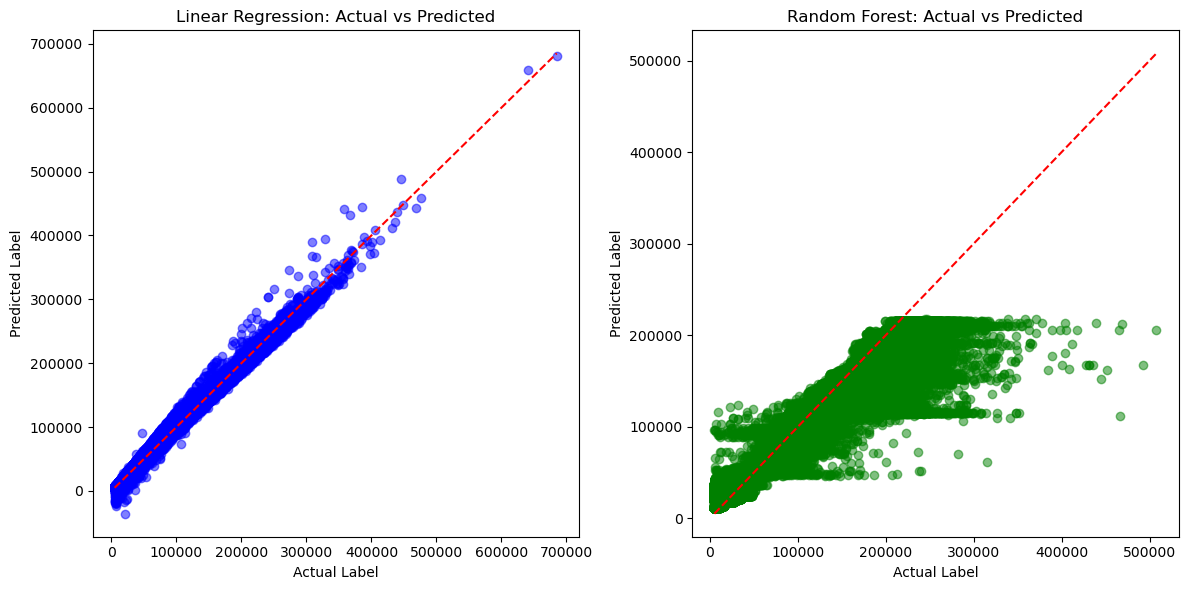

In [ ]:
lr_df = lr_predictions.select("prediction", "label").toPandas()
rf_df = rf_predictions.select("rf_prediction", "label").toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(lr_df['label'], lr_df['prediction'], alpha=0.5, color="blue")
plt.plot([lr_df['label'].min(), lr_df['label'].max()],
         [lr_df['label'].min(), lr_df['label'].max()],
         color='red', linestyle='--')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

plt.subplot(1, 2, 2)
plt.scatter(rf_df['label'], rf_df['rf_prediction'], alpha=0.5, color="green")
plt.plot([rf_df['label'].min(), rf_df['label'].max()],
         [rf_df['label'].min(), rf_df['label'].max()],
         color='red', linestyle='--')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

plt.tight_layout()
plt.show()

###Scaling Strategies

Scaling Up: Start with 20% of the dataset and incrementally increase to 40%, 60%, 80%, and 100%, evaluating model performance at each step.

Scaling Out : Gradually increase the cluster size to up to 8 executors, analyzing computational speed and model performance to determine the optimal configuration.


First, we applied Linear Regression, followed by Random Forest.


Processing 20% of data...


+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
| 441205.7668308908|         358349.38|
| 431339.7504096052|         366923.01|
|345227.31497226265|         272732.17|
|  366751.961713596|         315192.88|
| 280592.7516293115|          221755.6|
|270696.24022235407|          214995.1|
| 323330.3331194108|356592.86000000004|
| 269884.6706196036|224588.90000000002|
|298423.93972144887|          313569.8|
| 245496.7950698732|         200127.05|
| 308923.3477710426|324825.42999999993|
| 322781.8849619996|         348887.99|
|292063.37124021415|         320737.39|
| 297712.1953168791|         314412.18|
|292865.20451387175|312119.37000000005|
|283767.10712682485|303510.42000000004|
| 205708.2293522582|          162695.0|
|262357.42007263855|         287943.16|
|264610.50833192526|281978.47000000003|
|256815.71062342275|278619.81999999995|
+------------------+------------------+
only showing top 20 rows

Adjusted R2: 0

Mean Absolute Error (MAE): 1067.4052153942757
Time taken for 20%: 50.35 seconds
Processing 40% of data...


+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
| 441205.7666163096|         358349.38|
|431339.75026437116|         366923.01|
| 345227.3147704069|         272732.17|
|  366751.961602733|         315192.88|
| 280592.7514621831|          221755.6|
|270696.24006463506|          214995.1|
| 323330.3330430711|356592.86000000004|
| 269884.6704997457|224588.90000000002|
|  298423.939657763|          313569.8|
| 245496.7949480604|         200127.05|
|308923.34771907335|324825.42999999993|
|322781.88492731657|         348887.99|
| 292063.3711787447|         320737.39|
|297712.19526667363|         314412.18|
|292865.20447051665|312119.37000000005|
|283767.10707826435|303510.42000000004|
|205708.22922536847|          162695.0|
| 262357.4200202293|         287943.16|
| 264610.5082844446|281978.47000000003|
|256815.71057080643|278619.81999999995|
+------------------+------------------+
only showing top 20 rows

Adjusted R2: 0

Mean Absolute Error (MAE): 1067.4052162956652
Time taken for 40%: 51.40 seconds
Processing 60% of data...


+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|441205.76683261787|         358349.38|
|431339.75041155174|         366923.01|
| 345227.3149752269|         272732.17|
| 366751.9617127445|         315192.88|
| 280592.7516331426|          221755.6|
| 270696.2402263229|          214995.1|
| 323330.3330438571|356592.86000000004|
| 269884.6706228925|224588.90000000002|
| 298423.9396716368|          313569.8|
| 245496.7950705472|         200127.05|
|308923.34772270924|324825.42999999993|
|322781.88490160997|         348887.99|
| 292063.3711723653|         320737.39|
|297712.19526922004|         314412.18|
| 292865.2044657956|312119.37000000005|
|283767.10707316676|303510.42000000004|
| 205708.2293570946|          162695.0|
| 262357.4200135077|         287943.16|
|264610.50828740804|281978.47000000003|
|256815.71057333398|278619.81999999995|
+------------------+------------------+
only showing top 20 rows

Adjusted R2: 0

Mean Absolute Error (MAE): 1067.405212515547
Time taken for 60%: 49.46 seconds
Processing 80% of data...


+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|441205.76684661786|         358349.38|
| 431339.7504217657|         366923.01|
|345227.31498811196|         272732.17|
|366751.96172040247|         315192.88|
|280592.75164386583|          221755.6|
| 270696.2402364951|          214995.1|
|323330.33304095926|356592.86000000004|
| 269884.6706309339|224588.90000000002|
| 298423.9396708129|          313569.8|
|245496.79507825422|         200127.05|
|308923.34772148036|324825.42999999993|
| 322781.8848981654|         348887.99|
| 292063.3711693481|         320737.39|
| 297712.1952679064|         314412.18|
|292865.20446403447|312119.37000000005|
|  283767.107071004|303510.42000000004|
|205708.22936531258|          162695.0|
| 262357.4200108092|         287943.16|
| 264610.5082861063|281978.47000000003|
|256815.71057163502|278619.81999999995|
+------------------+------------------+
only showing top 20 rows

Adjusted R2: 0

Mean Absolute Error (MAE): 1067.4052121480686
Time taken for 80%: 49.06 seconds
Processing 100% of data...


+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
| 441205.7667336996|         358349.38|
| 431339.7503441091|         366923.01|
| 345227.3148817985|         272732.17|
| 366751.9616621118|         315192.88|
| 280592.7515552968|          221755.6|
|270696.24015272275|          214995.1|
|323330.33303731616|356592.86000000004|
|269884.67056677165|224588.90000000002|
| 298423.9396611409|          313569.8|
|245496.79501457157|         200127.05|
|308923.34771696257|324825.42999999993|
|322781.88490826986|         348887.99|
| 292063.3711697235|         320737.39|
| 297712.1952640417|         314412.18|
|292865.20446389867|312119.37000000005|
|  283767.107071034|303510.42000000004|
|205708.22929730418|          162695.0|
| 262357.4200117366|         287943.16|
|  264610.508282335|281978.47000000003|
|256815.71056805167|278619.81999999995|
+------------------+------------------+
only showing top 20 rows

Adjusted R2: 0

Mean Absolute Error (MAE): 1067.4052140144931
Time taken for 100%: 49.47 seconds


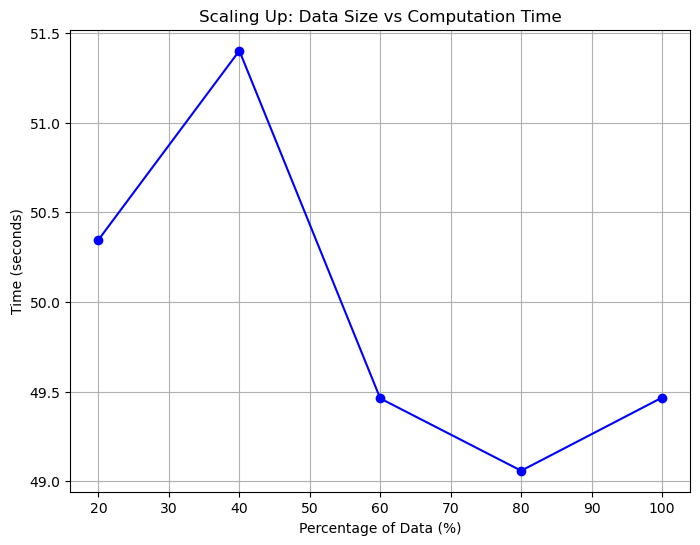

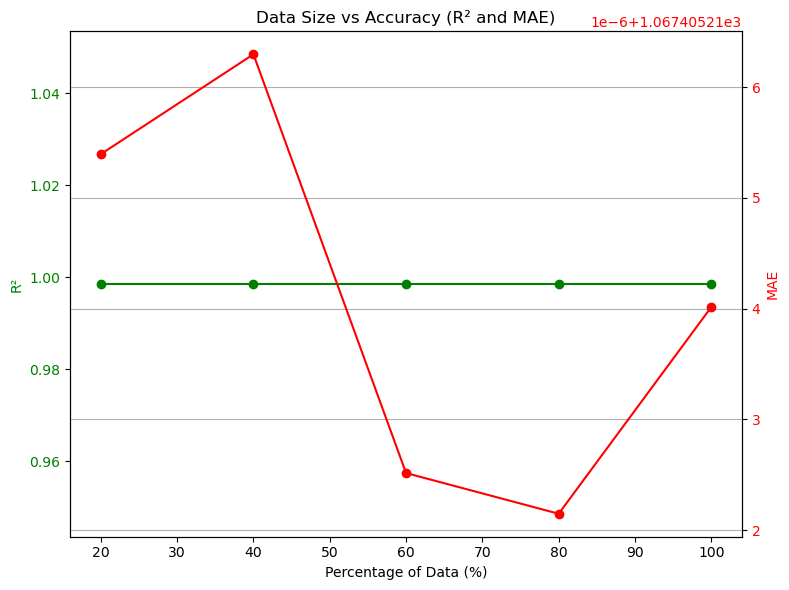

In [ ]:
scales = [0.2, 0.4, 0.6, 0.8, 1.0]
execution_times = []
r2_scores = []
mae_scores = []

def run_task(data):
    start_time = time.time()

    va = VectorAssembler(inputCols=continuous_cols, outputCol="features")
    assembled_data = va.transform(data)

    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
    scaled_data = scaler.fit(assembled_data).transform(assembled_data)

    pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pca_features")
    pca_model = pca.fit(scaled_data)
    pca_result = pca_model.transform(scaled_data)
    pca_result.select("scaledFeatures", "pca_features")


    final_data = pca_result.select(col("pca_features"), col("Total Pay Earned").alias("label"))

    train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

    lr = LinearRegression(featuresCol='pca_features', labelCol='label', predictionCol='prediction', regParam=0.1)

    lr_model = lr.fit(train_data)

    lr_predictions = lr_model.transform(test_data)
    lr_predictions.select("prediction", "label").show()

    training_summary = lr_model.summary

    n = training_summary.numInstances
    p = len(final_data.columns) - 1
    adjusted_r2 = 1 - (1 - training_summary.r2) * (n - 1) / (n - p - 1)
    print(f"Adjusted R2: {adjusted_r2}")

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
    mae = evaluator.evaluate(lr_predictions)
    r2_scores.append(adjusted_r2)
    mae_scores.append(mae)
    print(f"Mean Absolute Error (MAE): {mae}")
    end_time = time.time()
    return end_time - start_time

for scale in scales:
    print(f"Processing {int(scale * 100)}% of data...")
    sample_data = data.sample(withReplacement=False, fraction=scale, seed=42)
    time_taken = run_task(data)
    execution_times.append(time_taken)
    print(f"Time taken for {int(scale * 100)}%: {time_taken:.2f} seconds")

plt.figure(figsize=(8, 6))
plt.plot([int(s * 100) for s in scales], execution_times, marker='o', linestyle='-', color='blue')
plt.title("Scaling Up: Data Size vs Computation Time")
plt.xlabel("Percentage of Data (%)")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()



fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot([int(s * 100) for s in scales], r2_scores, marker='o', linestyle='-', color='green', label="Adjusted R²")
ax1.set_xlabel("Percentage of Data (%)")
ax1.set_ylabel("R²", color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot([int(s * 100) for s in scales], mae_scores, marker='o', linestyle='-', color='red', label="MAE")
ax2.set_ylabel("MAE", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Data Size vs Accuracy (R² and MAE)")
fig.tight_layout()
plt.grid(True)
plt.show()


Processing 20% of data...


24/12/22 21:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1343.8 KiB


Random Forest MAE: 7938.7113974976555


Random Forest Adjusted R2: 0.9294500985372631
Time taken for 20%: 142.98 seconds
Processing 40% of data...


24/12/22 21:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1047.3 KiB
24/12/22 21:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1474.7 KiB


Random Forest MAE: 8718.389992700275


Random Forest Adjusted R2: 0.9191986072666878
Time taken for 40%: 187.18 seconds
Processing 60% of data...


24/12/22 21:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1051.3 KiB
24/12/22 21:49:03 WARN DAGScheduler: Broadcasting large task binary with size 1451.1 KiB


Random Forest MAE: 9710.627016662846


Random Forest Adjusted R2: 0.9036274234442503
Time taken for 60%: 267.99 seconds
Processing 80% of data...


24/12/22 21:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1060.0 KiB
24/12/22 21:55:00 WARN DAGScheduler: Broadcasting large task binary with size 1463.3 KiB


Random Forest MAE: 8230.842813817002


Random Forest Adjusted R2: 0.9241590495118572
Time taken for 80%: 374.56 seconds
Processing 100% of data...


24/12/22 22:00:53 WARN DAGScheduler: Broadcasting large task binary with size 1053.6 KiB
24/12/22 22:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1455.4 KiB


Random Forest MAE: 8326.262407250191


Random Forest Adjusted R2: 0.9238448284282254
Time taken for 100%: 428.51 seconds


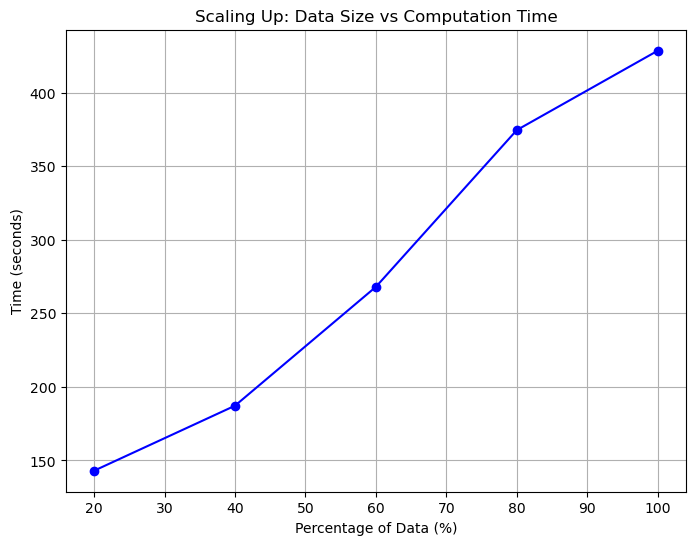

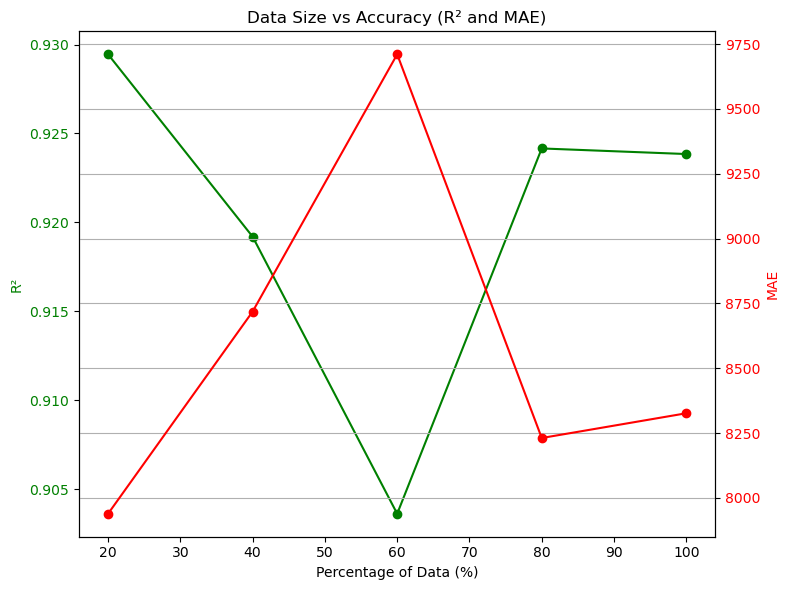

In [ ]:
scales = [0.2, 0.4, 0.6, 0.8, 1.0]
execution_times = []
r2_scores = []
mae_scores = []
def run_task(data):
    start_time = time.time()

    categorical_columns = ['Agency Name', 'Work Location Borough', 'Title Description']
    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip") for col in categorical_columns]
    encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in categorical_columns]
    numeric_columns = ['Fiscal Year', 'Regular Gross Paid', 'Total OT Paid', 'Total Other Pay']
    all_features = numeric_columns + [f"{col}_encoded" for col in categorical_columns]
    assembler = VectorAssembler(inputCols=all_features, outputCol="features")
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    processed_data = pipeline.fit(data).transform(data)

    final_data = processed_data.withColumnRenamed("Total Pay Earned", "label")
    final_data = final_data.filter(final_data.label.isNotNull() & final_data.features.isNotNull())
    train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


    rf = RandomForestRegressor(featuresCol="features", labelCol="label", predictionCol="rf_prediction")
    rf_model = rf.fit(train_data)

    rf_predictions = rf_model.transform(test_data)
    rf_predictions.select("rf_prediction", "label")
    evaluator_mae_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="mae")
    rf_mae = evaluator_mae_rf.evaluate(rf_predictions)
    mae_scores.append(rf_mae)
    print(f"Random Forest MAE: {rf_mae}")


    evaluator_r2_rf = RegressionEvaluator(labelCol="label", predictionCol="rf_prediction", metricName="r2")
    rf_r2 = evaluator_r2_rf.evaluate(rf_predictions)
    rf_n = final_data.count()
    rf_p = len(final_data.columns) - 1
    rf_adjusted_r2 = 1 - (1 - rf_r2) * (rf_n - 1) / (rf_n - rf_p - 1)
    r2_scores.append(rf_adjusted_r2)
    print(f"Random Forest Adjusted R2: {rf_adjusted_r2}")

    end_time = time.time()
    return end_time - start_time


for scale in scales:
    print(f"Processing {int(scale * 100)}% of data...")
    sample_data = data.sample(withReplacement=False, fraction=scale, seed=42)
    time_taken = run_task(sample_data)
    execution_times.append(time_taken)
    print(f"Time taken for {int(scale * 100)}%: {time_taken:.2f} seconds")


plt.figure(figsize=(8, 6))
plt.plot([int(s * 100) for s in scales], execution_times, marker='o', linestyle='-', color='blue')
plt.title("Scaling Up: Data Size vs Computation Time")
plt.xlabel("Percentage of Data (%)")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()




fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot([int(s * 100) for s in scales], r2_scores, marker='o', linestyle='-', color='green', label="Adjusted R²")
ax1.set_xlabel("Percentage of Data (%)")
ax1.set_ylabel("R²", color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot([int(s * 100) for s in scales], mae_scores, marker='o', linestyle='-', color='red', label="MAE")
ax2.set_ylabel("MAE", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Data Size vs Accuracy (R² and MAE)")
fig.tight_layout()
plt.grid(True)
plt.show()